11.2.1 데이터 불러오기

Resize
Premodel


In [1]:
import pandas as pd

data_path = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(data_path+'train.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')

In [2]:
# id - 파일 이름
# has_cactus : 선인장 유무 (1이 있음)
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


# EDA 및 시각화

11.2.2 데이터 시각화

타겟값 분포

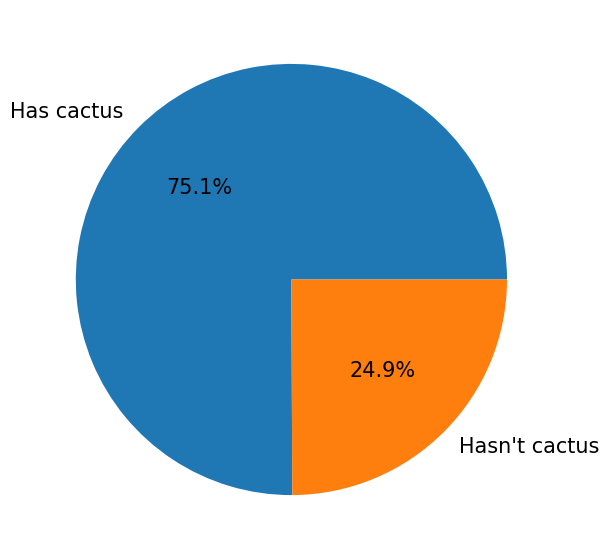

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus'] # target label

# 3:1 정도로, 선인장이 있는 경우가 더 많다.
plt.pie(labels['has_cactus'].value_counts(), labels = label, autopct='%.1f%%');

이미지 출력

In [5]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압출 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()
    
# 테스트 이미지 데이터 압출 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()
    
import os

num_train = len(os.listdir('train/'))
num_test = len(os.listdir('test/'))

print(f'훈련 데이터 개수 : {num_train}')
print(f'테스트 데이터 개수 : {num_test}')

훈련 데이터 개수 : 17500
테스트 데이터 개수 : 4000


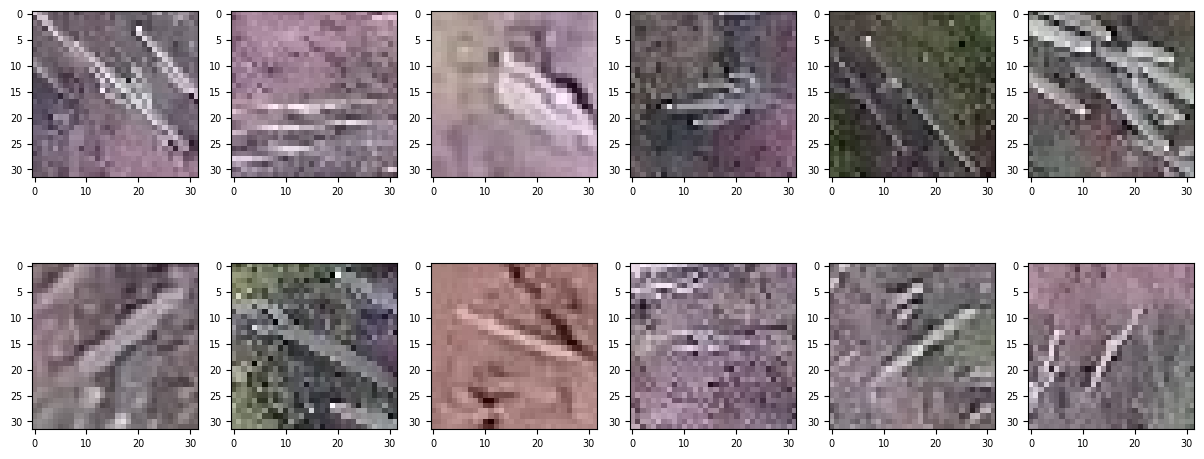

In [6]:
# 선인장을 포함한 사진 샘플

import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6)) # 전체 figure 크기
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치 2행 6열

# 선인장 포함 이미지 파일명(마지막 12개)
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'train/' + img_name # 이미지 파일 경로
    image = cv2.imread(img_path) # 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2는 기본이 BGR 이를 RGB로 변경
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

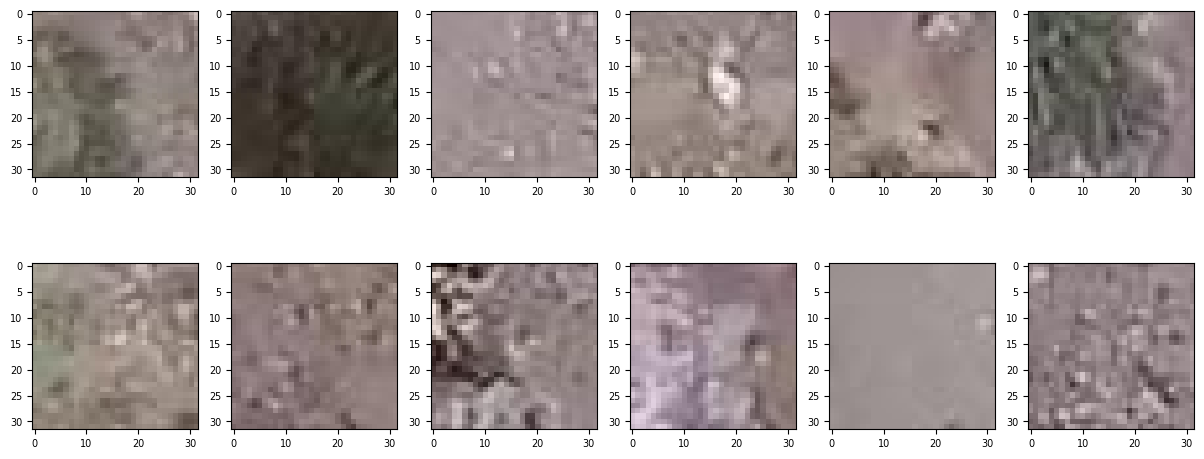

In [7]:
# 선인장을 포함하지 않은 사진 샘플

import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 6)

last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:] # 선인장을 포함하지 않는 파일들 마지막 12개

for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = 'train/' + img_name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

In [8]:
# 이미지 형상 (낮은 해상도 이미지)
# 빨강(R), 초록(G), 파랑(B)으로 이루어진 컬리 이미지
image.shape

(32, 32, 3)

# 11.3 베이스라인 모델

11.3.1 시드값 고정 및 GPU 설정

시드값 고정

In [9]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

GPU 장비 설정

In [10]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

11.3.2 데이터 준비

1. 훈련/검증 데이터 분리

2. 데이터셋 클래스 정의

3. 데이터셋 생성

4. 데이터 로더 생성

In [11]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/aerial-cactus-identification/'
# data_path = './Data/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [12]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()
    
# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

훈련데이터, 검증 데이터 분리

In [13]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1, # ⓐ
                                stratify=labels['has_cactus'], # ⓑ
                                random_state=50)


print(f'훈련 데이터 개수 : {len(train)}')
print(f'검증 데이터 개수 : {len(valid)}')

훈련 데이터 개수 : 15750
검증 데이터 개수 : 1750


데이터셋 클래스 정의

파이토치에서 제공하는 Dataset 클래스를 활용해 데이터셋 객체를 만들 수 있습니다. Dataset은 추상 클래스이며, 우리는 Dataset을 상속받은 다음 특수 메서드인 __len__()과 __getitem__()을 재정의(오버라이딩)해야 합니다.

 

● __len__() : 데이터셋 크기를 반환합니다.

● __getitem__() : 인덱스를 전달받아 인덱스에 해당하는 데이터를 반환합니다.

ⓐ __init__()는 ImageDataset 클래스의 초기화 메서드입니다. 
ⓑ 상속받은 Dataset의 초기화 메서드를 호출한 후 
ⓒ 파라미터로 받은 인수들을 저장합니다.
ⓓ __len__()은 데이터셋의 크기를 반환하는 메서드입니다. Dataset 클래스에 이미 정의되어 있는 메서드를 재정의하는 겁니다.
ⓔ __getitem__()은 지정한 인덱스에 해당하는 데이터를 반환하는 메서드입니다. 
ⓕ idx번째 이미지와 레이블(타깃값)을 반환합니다. 
ⓖ 초기화 메서드에서 받은 경로에 이미지 ID를 합쳐 이미지 위치를 알아내고,  
ⓗ 초기화 메서드에서 이미지 변환기(transform)를 받아뒀다면 변환 작업까지 수행한 후 반환합니다.

In [14]:
import cv2
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    # 생성자
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속 받은 Dataset 클래스의 생성자 호출
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    # 데이터셋 크기 변환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스에 해당하는 데이터 변환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # 이미지 id
        img_path = self.img_dir + img_id # 이미지 파일 경로
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # 파일 열어서 색상 보정
        label = self.df.iloc[idx, 1] # 이미지 레이블
        
        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 변환
        return image, label

데이터셋 생성

In [15]:
# 파이토치 모델로 이미지를 다루려면 이미지 데이터를 텐서 타입으로 바꿔야 
from torchvision import transforms # 이미지 변환을 위한 모듈

transform = transforms.ToTensor() # 이미지를 텐서로 변환 32x32x3 --> 3x32x32

# ToTensor() 메서드로 이미지를 텐서로 바꿨습니다. 이때 (가로 픽셀 수, 세로 픽셀 수, 채널 수) 형상이 (채널 수, 가로 픽셀 수, 세로 픽셀 수) 형상으로 바뀝니다. 파이토치로 이미지를 처리할 때는 형상이 (채널 수, 가로 픽셀 수, 세로 픽셀 수) 순서여야 합니다. 이번 대회의 이미지 데이터는 32 x 32 x 3 형상 이므로 3 x 32 x 32로 바뀐다는 의미
# 여기에 배치가 추가된다면 (배치 크기, 채널 수, 가로 픽셀 수, 세로 픽셀 수)가 됩니다.

In [16]:
# df 파라미터에는 훈련 데이터(train)나 검증 데이터(valid)를, img_dir에는 이미지 데이터가 저장되어 있는 경로를, transform에는 transform 변환기를 전달합니다.
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform)

데이터 로더 생성

In [17]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

11.3.3 모델 생성

In [18]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

In [19]:
class Model(nn.Module):
    # ⓐ 신경망 계층 정의 
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        
        # ⓑ 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, padding=2) 
        # ⓒ 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, padding=2) 
        # ⓓ 최대 풀링 계층 
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        # ⓔ 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=2) 
        # ⓕ 전결합 계층 
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    # ⓖ 순전파 출력 정의 
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x))) # ⓗ
        x = self.max_pool(F.relu(self.conv2(x))) # ⓘ
        x = self.avg_pool(x) # ⓙ
        x = x.view(-1, 64 * 4 * 4) # ⓚ 평탄화
        x = self.fc(x) # ⓛ
        return x

ⓐ 초기화 메서드인 __init__()에서 모델에서 쓸 신경망 계층들을 정의합니다. 여기서 정의한 계층들을 ⓖ forward() 메서드에서 조합해 모델을 완성시키는데 사용됩니다.
 

합성곱 신경망 계층인 ⓑ와 ⓒ은 nn.Conv2d()로 정의할 수 있습니다. nn.Conv2d() 파라미터는 다음과 같습니다.
 

● torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

○ in_channels : 입력 데이터의 채널수

○ out_channels : 출력 데이터의 채널 수

○ kernel_size : 필터(커널) 크기

○ stride : 스트라이드 크기

○ padding : 패딩 크기

 합성곱 계층 ⓑ를 예시로 설명하겠습니다. 앞서 ToTensor() 메서드로 이미지 형상을 (3,32,32)로 변환했으니 in_channels 파라미터에는 3을 전달합니다. 출력 데이터의 채널 수(out_channels)에는 원하는 값을 전달하면 됩니다. 여기서는 32를 전달했습니다. 나머지 값들은 원하는 대로 설정하면 됩니다. 스트라이드는 명시하지 않아 기본값인 1이 사용됩니다.

풀링 계층 ⓓ와 ⓔ의 크기는 모두 2로 설정했습니다.  이때, 스트라이드 크기를 설정하는 stride 파라미터를 명시하지 않으면 기본적으로 스트라이드 크기는 풀링 크기와 동일하게 설정됩니다.

ⓕ은 전결합 계층을 정의합니다. nn.Linear()로 구현할 수 있는데, in_features 파라미터에는 입력값 개수를,  out_features 파라미터에는 최종 출력값 개수를 전달합니다. 최종 출력값은 0일 확률과 1일 확률이므로 그 개수는 2개입니다.

ⓖ forward()는 순전파 출력을 계산하는 메서드입니다. 

__init__()에서 정의한 합성곱 계층, 풀링 계층, 전결합 계층을 활용해 순전파 출력을 구합니다. ⓗ 먼저 첫 번째 합성곱 연상 -> ReLU 활성화 함수 -> 최대 풀링을 차례로 수행합니다. 이어서 ⓘ 는 두 번째 합성곱 연산 -> ReLU 활성화 함수 -> 최대 풀링을 수행합니다. 그다음 ⓙ 평균 풀링 -> ⓚ 평탄화 -> ⓛ 전결합을 거쳐 순전파가 마무리됩니다. 

In [20]:
model = Model().to(device)

11.3.4 모델 훈련

손실 함수 설정

In [21]:
criterion = nn.CrossEntropyLoss()
#손실 함수로 딥러닝 분류 문제에서 자주 사용하는 교차 엔트로피를 사용

옵티마이저 설정

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

모델 훈련
1. 데이터 로더에서 배치 크기만큼 데이터를 불러옵니다.

2. 불러온 이미지 데이터와 레이블(타깃값) 데이터를 장비(GPU 혹은 CPU)에 할당합니다.

3. 옵티마이저 내 기울기를 초기화합니다.

4. 신경망 모델에 입력 데이터(이미지)를 전달해 순전파하여 출력값(예측값)을 구합니다.

5. 예측값과 실제 레이블(타깃값)을 비교해 손실을 계산합니다.

6. 손실을 기반으로 역전파를 수행합니다.

7. 역전파로 구한 기울기를 활용해 가중치를 갱신합니다.

8. 1~7 절차를 반복 횟수만큼 되풀이합니다.

9. 1~8 절차를 에폭만큼 반복합니다.

In [23]:
epochs = 10 # 총 에폭
# ⓐ 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # ⓑ '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # ⓒ 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # ⓓ 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # ⓔ 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # ⓕ 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        #  현재 배치에서의 손실 추가
        epoch_loss += loss.item() # ⓖ 역전파 수행
        loss.backward()
        # ⓗ 가중치 갱신
        optimizer.step()
        
    # ⓘ 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] - 손실값: 0.5233
에폭 [2/10] - 손실값: 0.3453
에폭 [3/10] - 손실값: 0.2370
에폭 [4/10] - 손실값: 0.1984
에폭 [5/10] - 손실값: 0.1754
에폭 [6/10] - 손실값: 0.1666
에폭 [7/10] - 손실값: 0.1545
에폭 [8/10] - 손실값: 0.1439
에폭 [9/10] - 손실값: 0.1333
에폭 [10/10] - 손실값: 0.1299


ⓐ 바깥 for문은 에폭 수(10)만큼 반복하며 ⓘ 에폭이 하나 끝날 때마다 손실값을 출력합니다.

ⓑ 안쪽 for문은 반복 횟수(= 데이터 로더의 길이 = 493번)만큼 반복되며, 매번 데이터 로더(loader_trian)로부터 배치 크기(32)만큼의 이미지와 레이블을 추출해 images와 labels 변수에 할당해놓습니다.

그러면 ⓒ에서 이미지와 레이블 데이터를 장비에 할당하여 훈련 시 GPU를 활용하도록 해둡니다.

ⓓ 는 옵티마이저에 저장된 기울기를 초기화하는 코드입니다.

ⓔ 그다음으로 모델에 이미지 데이터를 입력하여 순전파를 진행한 다음, ⓕ 그 결과(outputs)와 실제 레이블(labels)을 비교해 손실을 구합니다. model과 criterion은 앞에서 정의한 CNN 모델과 교차 엔트로피 오차 손실 함수입니다.

ⓖ 이어서 역전파를 수행합니다. 바꿔 말하면, 손실값을 바탕으로 신경망의 가중치(파라미터)에 기울기를 할당합니다.

ⓗ 마지막으로 기중치를 갱신합니다.

optimizer.zero_grad()가 없다면 기존 기울기가 계속 누적됩니다. 기존 기울기를 초기화하는 작업이 필요한데,  optimizer.zero_grad()가 이를 수행합니다.

11.3.5 성능 검증

In [24]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
# true_list에는 실젯값을, preds_list에는 예측 확률을 담을 것
true_list = []
preds_list = []

In [25]:
# 모델을 평가 상태로 설정
model.eval()

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률
        true = labels.cpu() # 계산을 하기 위해 CPU로 설정
        preds_list += preds # 예측값
        true_list += true # 실젯값

# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 roc auc : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 roc auc : 0.9902


11.3.6 예측 및 결과 제출

In [26]:
# dataset_test = ImageDataset(df=submission, img_dir=data_path+'test/', transform=transform)
dataset_test = ImageDataset(df=submission, img_dir='test/', transform=transform)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

예측

In [27]:
model.eval() # 모델을 평가 상태로 설정

preds = [] # ⓐ 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # ⓑ 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # ⓒ preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [28]:
submission['has_cactus'] = preds
submission.to_csv('submission_1.csv', index=False)

# 개선

11.4.1 데이터 준비

In [29]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

# from zipfile import ZipFile

# # 훈련 이미지 데이터 압축 풀기
# with ZipFile(data_path + 'train.zip') as zipper:
#     zipper.extractall()
    
# # 테스트 이미지 데이터 압축 풀기
# with ZipFile(data_path + 'test.zip') as zipper:
#     zipper.extractall()

In [30]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [31]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

이미지 변환기 정의

In [32]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

데이터셋 및 데이터 로더 생성

In [33]:
dataset_train = ImageDataset(df=train, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)

In [34]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

11.4.2 모델 생성

In [35]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [36]:
model = Model().to(device)

11.4.3 모델 훈련

손실 함수와 옵티마이저 설정

In [37]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

모델 훈련

In [38]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')    

에폭 [1/70] - 손실값: 0.1306
에폭 [2/70] - 손실값: 0.0702
에폭 [3/70] - 손실값: 0.0564
에폭 [4/70] - 손실값: 0.0507
에폭 [5/70] - 손실값: 0.0414
에폭 [6/70] - 손실값: 0.0406
에폭 [7/70] - 손실값: 0.0364
에폭 [8/70] - 손실값: 0.0351
에폭 [9/70] - 손실값: 0.0317
에폭 [10/70] - 손실값: 0.0310
에폭 [11/70] - 손실값: 0.0260
에폭 [12/70] - 손실값: 0.0266
에폭 [13/70] - 손실값: 0.0247
에폭 [14/70] - 손실값: 0.0233
에폭 [15/70] - 손실값: 0.0227
에폭 [16/70] - 손실값: 0.0226
에폭 [17/70] - 손실값: 0.0202
에폭 [18/70] - 손실값: 0.0198
에폭 [19/70] - 손실값: 0.0171
에폭 [20/70] - 손실값: 0.0180
에폭 [21/70] - 손실값: 0.0167
에폭 [22/70] - 손실값: 0.0177
에폭 [23/70] - 손실값: 0.0169
에폭 [24/70] - 손실값: 0.0169
에폭 [25/70] - 손실값: 0.0147
에폭 [26/70] - 손실값: 0.0155
에폭 [27/70] - 손실값: 0.0163
에폭 [28/70] - 손실값: 0.0149
에폭 [29/70] - 손실값: 0.0162
에폭 [30/70] - 손실값: 0.0120
에폭 [31/70] - 손실값: 0.0114
에폭 [32/70] - 손실값: 0.0115
에폭 [33/70] - 손실값: 0.0109
에폭 [34/70] - 손실값: 0.0103
에폭 [35/70] - 손실값: 0.0123
에폭 [36/70] - 손실값: 0.0116
에폭 [37/70] - 손실값: 0.0101
에폭 [38/70] - 손실값: 0.0109
에폭 [39/70] - 손실값: 0.0106
에폭 [40/70] - 손실값: 0.0092
에폭 [41/70

11.4.4 성능 검증

In [39]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')    

검증 데이터 ROC AUC : 0.9998


11.4.5 예측 및 결과 제출

In [40]:
dataset_test = ImageDataset(df=submission, img_dir='test/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [41]:
submission['has_cactus'] = preds
submission.to_csv('submission02.csv', index=False)

In [42]:
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')

# 추가개선 02

In [43]:
import pandas as pd

# 데이터 경로
data_path = '/kaggle/input/aerial-cactus-identification/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [44]:
from zipfile import ZipFile

# 훈련 이미지 데이터 압축 풀기
with ZipFile(data_path + 'train.zip') as zipper:
    zipper.extractall()
    
# 테스트 이미지 데이터 압축 풀기
with ZipFile(data_path + 'test.zip') as zipper:
    zipper.extractall()

In [45]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
_, valid = train_test_split(labels, 
                            test_size=0.1,
                            stratify=labels['has_cactus'],
                            random_state=50)

In [46]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [47]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [48]:
dataset_train = ImageDataset(df=labels, img_dir='train/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir='train/', transform=transform_test)

In [49]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [50]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [51]:
model = Model().to(device)

In [52]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [ ]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')    

에폭 [1/70] - 손실값: 0.1145
에폭 [2/70] - 손실값: 0.0608
에폭 [3/70] - 손실값: 0.0490
에폭 [4/70] - 손실값: 0.0437
에폭 [5/70] - 손실값: 0.0364
에폭 [6/70] - 손실값: 0.0344
에폭 [7/70] - 손실값: 0.0293
에폭 [8/70] - 손실값: 0.0283
에폭 [9/70] - 손실값: 0.0246
에폭 [10/70] - 손실값: 0.0249
에폭 [11/70] - 손실값: 0.0225
에폭 [12/70] - 손실값: 0.0211
에폭 [13/70] - 손실값: 0.0179
에폭 [14/70] - 손실값: 0.0172
에폭 [15/70] - 손실값: 0.0186
에폭 [16/70] - 손실값: 0.0181
에폭 [17/70] - 손실값: 0.0159
에폭 [18/70] - 손실값: 0.0157
에폭 [19/70] - 손실값: 0.0148
에폭 [20/70] - 손실값: 0.0128
에폭 [21/70] - 손실값: 0.0127
에폭 [22/70] - 손실값: 0.0136
에폭 [23/70] - 손실값: 0.0131
에폭 [24/70] - 손실값: 0.0120
에폭 [25/70] - 손실값: 0.0103
에폭 [26/70] - 손실값: 0.0095
에폭 [27/70] - 손실값: 0.0111
에폭 [28/70] - 손실값: 0.0101
에폭 [29/70] - 손실값: 0.0088
에폭 [30/70] - 손실값: 0.0082
에폭 [31/70] - 손실값: 0.0092
에폭 [32/70] - 손실값: 0.0102
에폭 [33/70] - 손실값: 0.0104
에폭 [34/70] - 손실값: 0.0092
에폭 [35/70] - 손실값: 0.0078
에폭 [36/70] - 손실값: 0.0069
에폭 [37/70] - 손실값: 0.0077
에폭 [38/70] - 손실값: 0.0079
에폭 [39/70] - 손실값: 0.0082
에폭 [40/70] - 손실값: 0.0055
에폭 [41/70

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')    

In [ ]:
dataset_test = ImageDataset(df=submission, img_dir='test/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [ ]:
submission['has_cactus'] = preds
submission.to_csv('submission03.csv', index=False)

In [ ]:
import shutil

shutil.rmtree('./train')
shutil.rmtree('./test')